# Final Project

This project analyzes household-level retail transactions for frequent shoppers at a single retailer. The dataset includes household demographics and all recorded purchases during the study period.

* **Data Loading and column selection:** Load the transactions dataset and keep only the coulms required for analysis.

* **Type optimization.** Cast selected columns to smaller integer/float typers to reduce memory usage without losing information.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
transactions = pd.read_csv("/content/project_transactions.csv", usecols=["household_key", "BASKET_ID", "DAY", "PRODUCT_ID", "QUANTITY", "SALES_VALUE"])

In [ ]:
transactions.describe().round()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
count,2146311.0,2.146311e+06,2146311.0,2146311.0,2146311.0,2146311.0
mean,1056.0,3.404897e+10,390.0,2884715.0,101.0,3.0
std,605.0,4.723748e+09,190.0,3831949.0,1152.0,4.0
min,1.0,2.698490e+10,1.0,25671.0,0.0,0.0
25%,548.0,3.040798e+10,229.0,917231.0,1.0,1.0
50%,1042.0,3.281176e+10,392.0,1027960.0,1.0,2.0
75%,1581.0,4.012804e+10,555.0,1132771.0,1.0,3.0
max,2099.0,4.230536e+10,711.0,18316298.0,89638.0,840.0


In [ ]:
transactions = transactions.astype({"household_key":"int16", "DAY":"int16", "QUANTITY":"int32"})

In [ ]:
transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int16  
 1   BASKET_ID      int64  
 2   DAY            int16  
 3   PRODUCT_ID     int64  
 4   QUANTITY       int32  
 5   SALES_VALUE    float64
dtypes: float64(1), int16(2), int32(1), int64(2)
memory usage: 65.5 MB


In [ ]:
# This column converts the day column into an actual date

transactions = (
    transactions
    .assign(date = (pd.to_datetime("2016", format='%Y')
                    + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + " days"))
           )
    .drop(["DAY"], axis=1)
)

## Time based analysis.

* **Objective:** Assess whether sales grow over time.
* **Method.** Aggregate monthly sales using a time-series resample and visualize the trend.

/tmp/ipython-input-1366276199.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


<Axes: xlabel='date'>

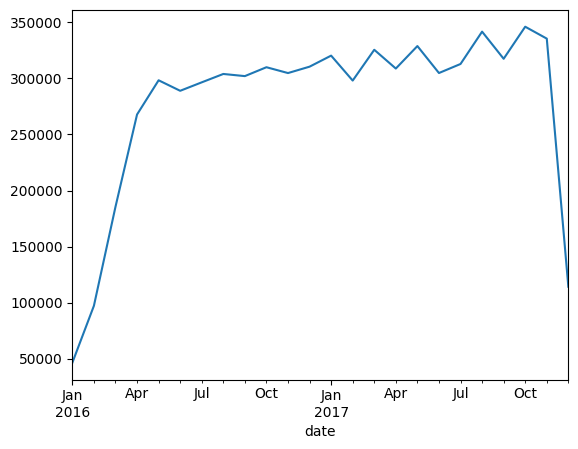

In [ ]:
(transactions
 .set_index("date")
.loc[:,"SALES_VALUE"]
.resample("M")
.sum()
.plot())

* As the data seems to have some inconsistencies in the period before april 2016 and after october 2017 we filter out those periods to see the trend the data takes ove time

/tmp/ipython-input-2352634279.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  transactions.set_index("date").sort_index().loc["2016-04":"2017-11", "SALES_VALUE"].resample("M").sum().plot()


<Axes: xlabel='date'>

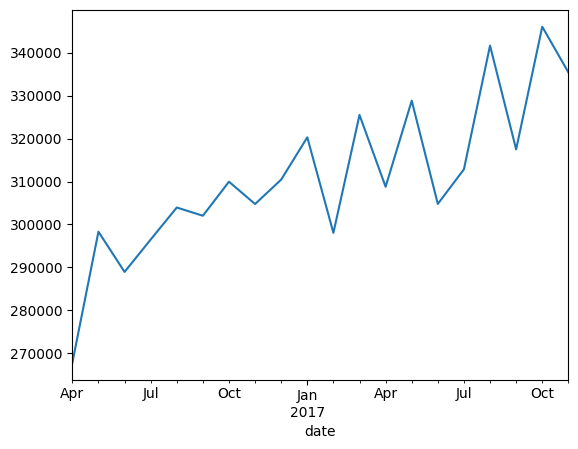

In [ ]:
transactions.set_index("date").sort_index().loc["2016-04":"2017-11", "SALES_VALUE"].resample("M").sum().plot()

* Year-over-year comparison. Plot 2016 and 2017 on the same monthly scale to compare seasonal patterns (YoY).

/tmp/ipython-input-1784777037.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


Text(0, 0.5, 'Sales value')

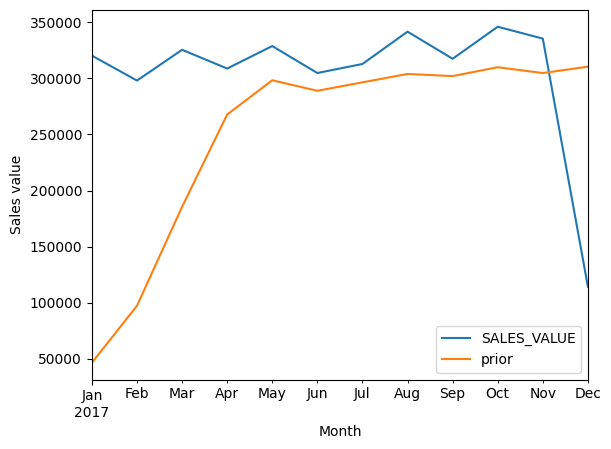

In [ ]:
ax = (transactions.set_index("date").loc[:, ["SALES_VALUE"]]
      .resample("M")
      .sum()
      .sort_index()
      .assign(prior = lambda x: x["SALES_VALUE"].shift(12))
      .loc["2017"].plot())
ax.set_xlabel("Month")
ax.set_ylabel("Sales value")

* Day-of-week pattern. Identify which weekdays concentrate the highest sales.

Text(0, 0.5, 'Sum Of Sales')

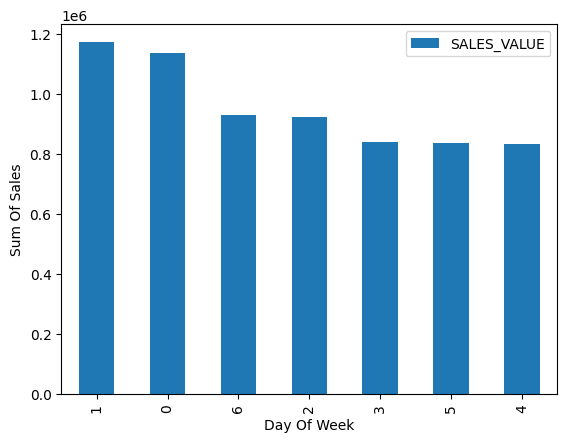

In [ ]:
ax = (transactions.groupby(transactions["date"].dt.day_of_week)
.agg({"SALES_VALUE":"sum"})
.sort_values(by= "SALES_VALUE", ascending=False).plot.bar())
ax.set_xlabel("Day Of Week")
ax.set_ylabel("Sum Of Sales")

# DEMOGRAPHICS

* **Objective:** Analyze sales across age groups

* **Method:** Merge our demographic table to the one previously created.

* **Data Loading and column selection:** Load `hh_demographic.csv`, and take the columns needed for the analysis: (`AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`), to make the memory usage better we will convert all the columns, except `household_key` to category.

In [ ]:
demographic = pd.read_csv("/content/hh_demographic.csv", usecols=["AGE_DESC", "INCOME_DESC", "household_key", "HH_COMP_DESC"])

In [ ]:
demographic = demographic.astype({"AGE_DESC":"category", "INCOME_DESC":"category", "HH_COMP_DESC":"category"})

In [ ]:
demographic.dtypes

,0
AGE_DESC,category
INCOME_DESC,category
HH_COMP_DESC,category
household_key,int64


* ## Age group study

* **Auxiliary table creation** A table with the total sales by household will be created, this table will be merged with the demographic table uploaded.

In [ ]:
household_sales = transactions.groupby("household_key").agg({"SALES_VALUE":"sum"})

In [ ]:
merged = (demographic.merge(
    household_sales,
    how="inner",
    left_on= "household_key",
    right_on="household_key"
))

/tmp/ipython-input-659419546.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = (merged.groupby("AGE_DESC")


Text(0, 0.5, 'Total Sales')

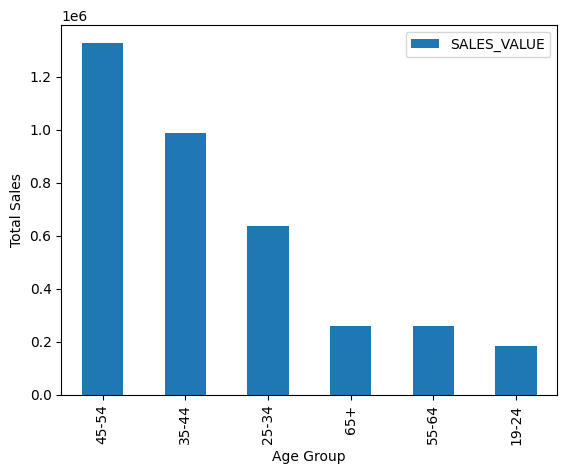

In [ ]:
ax = (merged.groupby("AGE_DESC")
.agg({"SALES_VALUE":"sum"})
.sort_values(by="SALES_VALUE", ascending=False).plot.bar())

ax.set_xlabel("Age Group")
ax.set_ylabel("Total Sales")

* ## Income group study

* The merged table previously created will be used to plot the amount of sales by household's Income

/tmp/ipython-input-1177596116.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = (merged.groupby("INCOME_DESC").agg({"SALES_VALUE":"sum"}).sort_values(by="SALES_VALUE", ascending=False).plot.bar())


Text(0, 0.5, 'Total Sales')

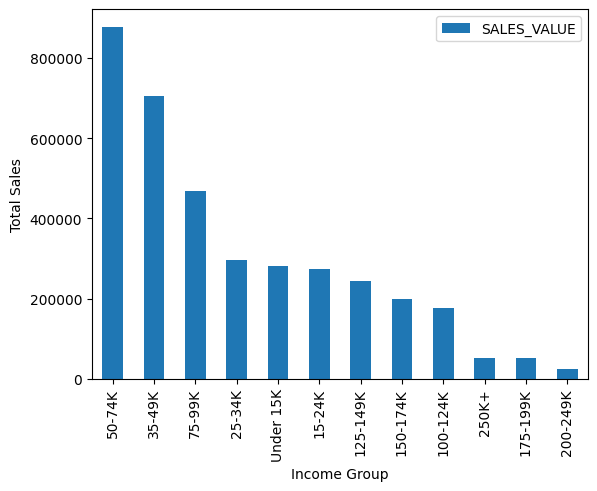

In [ ]:
ax = (merged.groupby("INCOME_DESC").agg({"SALES_VALUE":"sum"}).sort_values(by="SALES_VALUE", ascending=False).plot.bar())

ax.set_xlabel("Income Group")
ax.set_ylabel("Total Sales")

* Dataset is pivoted and plotted as a color map so we can easily see which demographics are performing better

In [ ]:
merged.pivot_table(
    index="AGE_DESC",
    columns="HH_COMP_DESC",
    values="SALES_VALUE",
    aggfunc="mean",
    margins=True
    ).style.background_gradient(cmap="RdYlGn", axis=None)


/tmp/ipython-input-2904540222.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  merged.pivot_table(


HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
AGE_DESC,,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000,4692.077692
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000,5435.517521
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818,6090.556728
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682,5534.879958
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000,5168.924200
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000,4340.936500
All,6032.802143,6280.069103,5599.857756,4895.928361,4544.646750,4936.127778,5468.398743


# PRODUCT DEMOGRAPHICS

* For this analysis we will need another dataset in this case that dataset is going to be `product.csv`, when uploaded we will select the columns needed to carry out the analysis. Our final goal is to see how each product category is performing across the different age groups.



In [ ]:
cols = ["PRODUCT_ID", "DEPARTMENT"]
products = pd.read_csv("/content/product.csv", usecols= cols, dtype={"PRODUCT_ID":"Int32", "DEPARTMENT":"category"})

* Now we merge the three tables to get a full table that includes all the necessary information to perform the analysis.

In [ ]:
fulltable = (transactions
.merge(
    demographic,
    how="inner",
    left_on="household_key",
    right_on="household_key"
)
.merge(
    products,
    how="inner",
    left_on="PRODUCT_ID",
    right_on="PRODUCT_ID"
))

* And finally we can pivot the data, we make use of a color map to graphically see the performance of each product category across each age group.

In [ ]:
fulltable.pivot_table(values="SALES_VALUE",
                      index= "DEPARTMENT",
                      columns="AGE_DESC",
                      aggfunc="sum").style.background_gradient(cmap="RdYlGn", axis=1)

/tmp/ipython-input-3920427966.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fulltable.pivot_table(values="SALES_VALUE",


AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


#Conclusions

- Sales increased steadily from mid-2016 until late 2017, then slowed.  
- Sundays and Mondays generated the highest sales volume.  
- Year-over-year patterns show consistent seasonality.  

# EXPORT

And finally, we make our chart available for downloading.

In [ ]:
(
    fulltable.pivot_table(values="SALES_VALUE",
                      index= "DEPARTMENT",
                      columns="AGE_DESC",
                      aggfunc="sum").style.background_gradient(cmap="RdYlGn", axis=1).
                      to_excel("demographic_category_sales.xlsx", sheet_name = "sales pivot")
)

/tmp/ipython-input-719117448.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fulltable.pivot_table(values="SALES_VALUE",


This line of code was used during the project building phase, I used Google Colab, I left the code available in case you run the code from Google Colab and want to see the final result.

In [ ]:
from google.colab import files

# Download the Excel file
files.download("demographic_category_sales.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>